# The time evolution of Rabi Hamiltonian

In [1]:
# Frount matter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as la


#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'

with open("psi.pickle", "rb") as f0:
    psi = pickle.load(f0)
with open("E.pickle", "rb") as f1:
    E = pickle.load(f1)

In [2]:
# Basic constants and parameters
# grid points
N=2000

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)
X2=np.linspace(XMin, XMax, 2*N)
dx = X[1] - X[0]

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(0,N//2), np.arange(-N//2,0)))
P2 = np.array([x for x in P for _ in range(2)])


# simulation points
M = 500                 

# initial and final conditions
w0=0.35
w1=1
dw = (w1-w0)/M

#define pauli matrixes
S0 = np.array([[1, 0], [0, 1]])
S1 = np.array([[0, 1], [1, 0]])
S3 = np.array([[1, 0], [0, -1]])

n=50

## Time operator

In [3]:
def simulation(a,b,v,tau,dt):
    M = int(tau/dt)
    psi_0 = psi[0,a,b][v]
    psi_1 = np.zeros(2*N, dtype=np.complex128)
    psi_2 = np.zeros(2*N, dtype=np.complex128)
    psi_3 = np.zeros(2*N, dtype=np.complex128)

    UT = np.exp(-1j*(P**2/2)*dt/2)

    for m in range(M):
        # momentum 1/2 update
        # saperate spin up and down
        psi_0_up = psi_0[::2]    
        phi_0_up = np.fft.fft(psi_0_up) 
        phi_1_up = UT*phi_0_up
        psi_1_up = np.fft.ifft(phi_1_up)

        psi_0_down=psi_0[1::2]
        phi_0_down = np.fft.fft(psi_0_down)
        phi_1_down= UT*phi_0_down
        psi_1_down=np.fft.ifft(phi_1_down)

        psi_1[::2] = psi_1_up
        psi_1[1::2] = psi_1_down

        w= w0+((w1-w0)/M)*m
        Vcase = np.einsum('i,jk->ijk', (w*X)**2/2, S0) + np.einsum('i,jk->ijk', a*X, S1) + b*S3
        UV = la.expm(-1j*Vcase*0.25)
        psi_2 = np.einsum('ijk,ik->ij', UV, psi_1.reshape(-1, 2))
        psi_2 = psi_2.reshape(-1)
        
        # momentum 1/2 update
        # saperate spin up and down
        psi_2_up = psi_2[::2]    
        phi_2_up = np.fft.fft(psi_2_up) 
        phi_3_up = UT*phi_2_up
        psi_3_up = np.fft.ifft(phi_3_up)

        psi_2_down=psi_2[1::2]
        phi_2_down = np.fft.fft(psi_2_down)
        phi_3_down= UT*phi_2_down
        psi_3_down=np.fft.ifft(phi_3_down)

        # combine up and down
        psi_3[::2] = psi_3_up
        psi_3[1::2] = psi_3_down

        psi_0 = psi_3
    return psi_0

## Store

In [6]:
# Add new data 
# Load the existing data
with open("simulation.pickle", "rb") as f2:
    psit_store = pickle.load(f2)

# Add new data
for a in [0, 0.25, 0.5, 0.75, 1]:
    for b in [0, 0.25, 0.5, 0.75, 1]:
        for v in range(n):
            for tau in [5,50,100,500,1000]:
                key = (a, b, v, tau)
                psit_store[key] = simulation(a, b, v, tau, 0.25)

# Save the updated data
with open("simulation.pickle", "wb") as f2:
    pickle.dump(psit_store, f2)

## Check out

In [7]:
# Read data
with open("simulation.pickle", "rb") as f2:
    psit = pickle.load(f2)

In [8]:
# Key ranges
keys = list(psit.keys())
name=['a','b','v','tau']
for i in range(4):
    chars = [key[i] for key in keys]
    chars = list(set(chars))
    chars.sort()
    print(f"{name[i]}: {chars}")

a: [0, 0.25, 0.5, 0.75, 1]
b: [0, 0.25, 0.5, 0.75, 1]
v: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
tau: [0, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000, 5000, 6000]


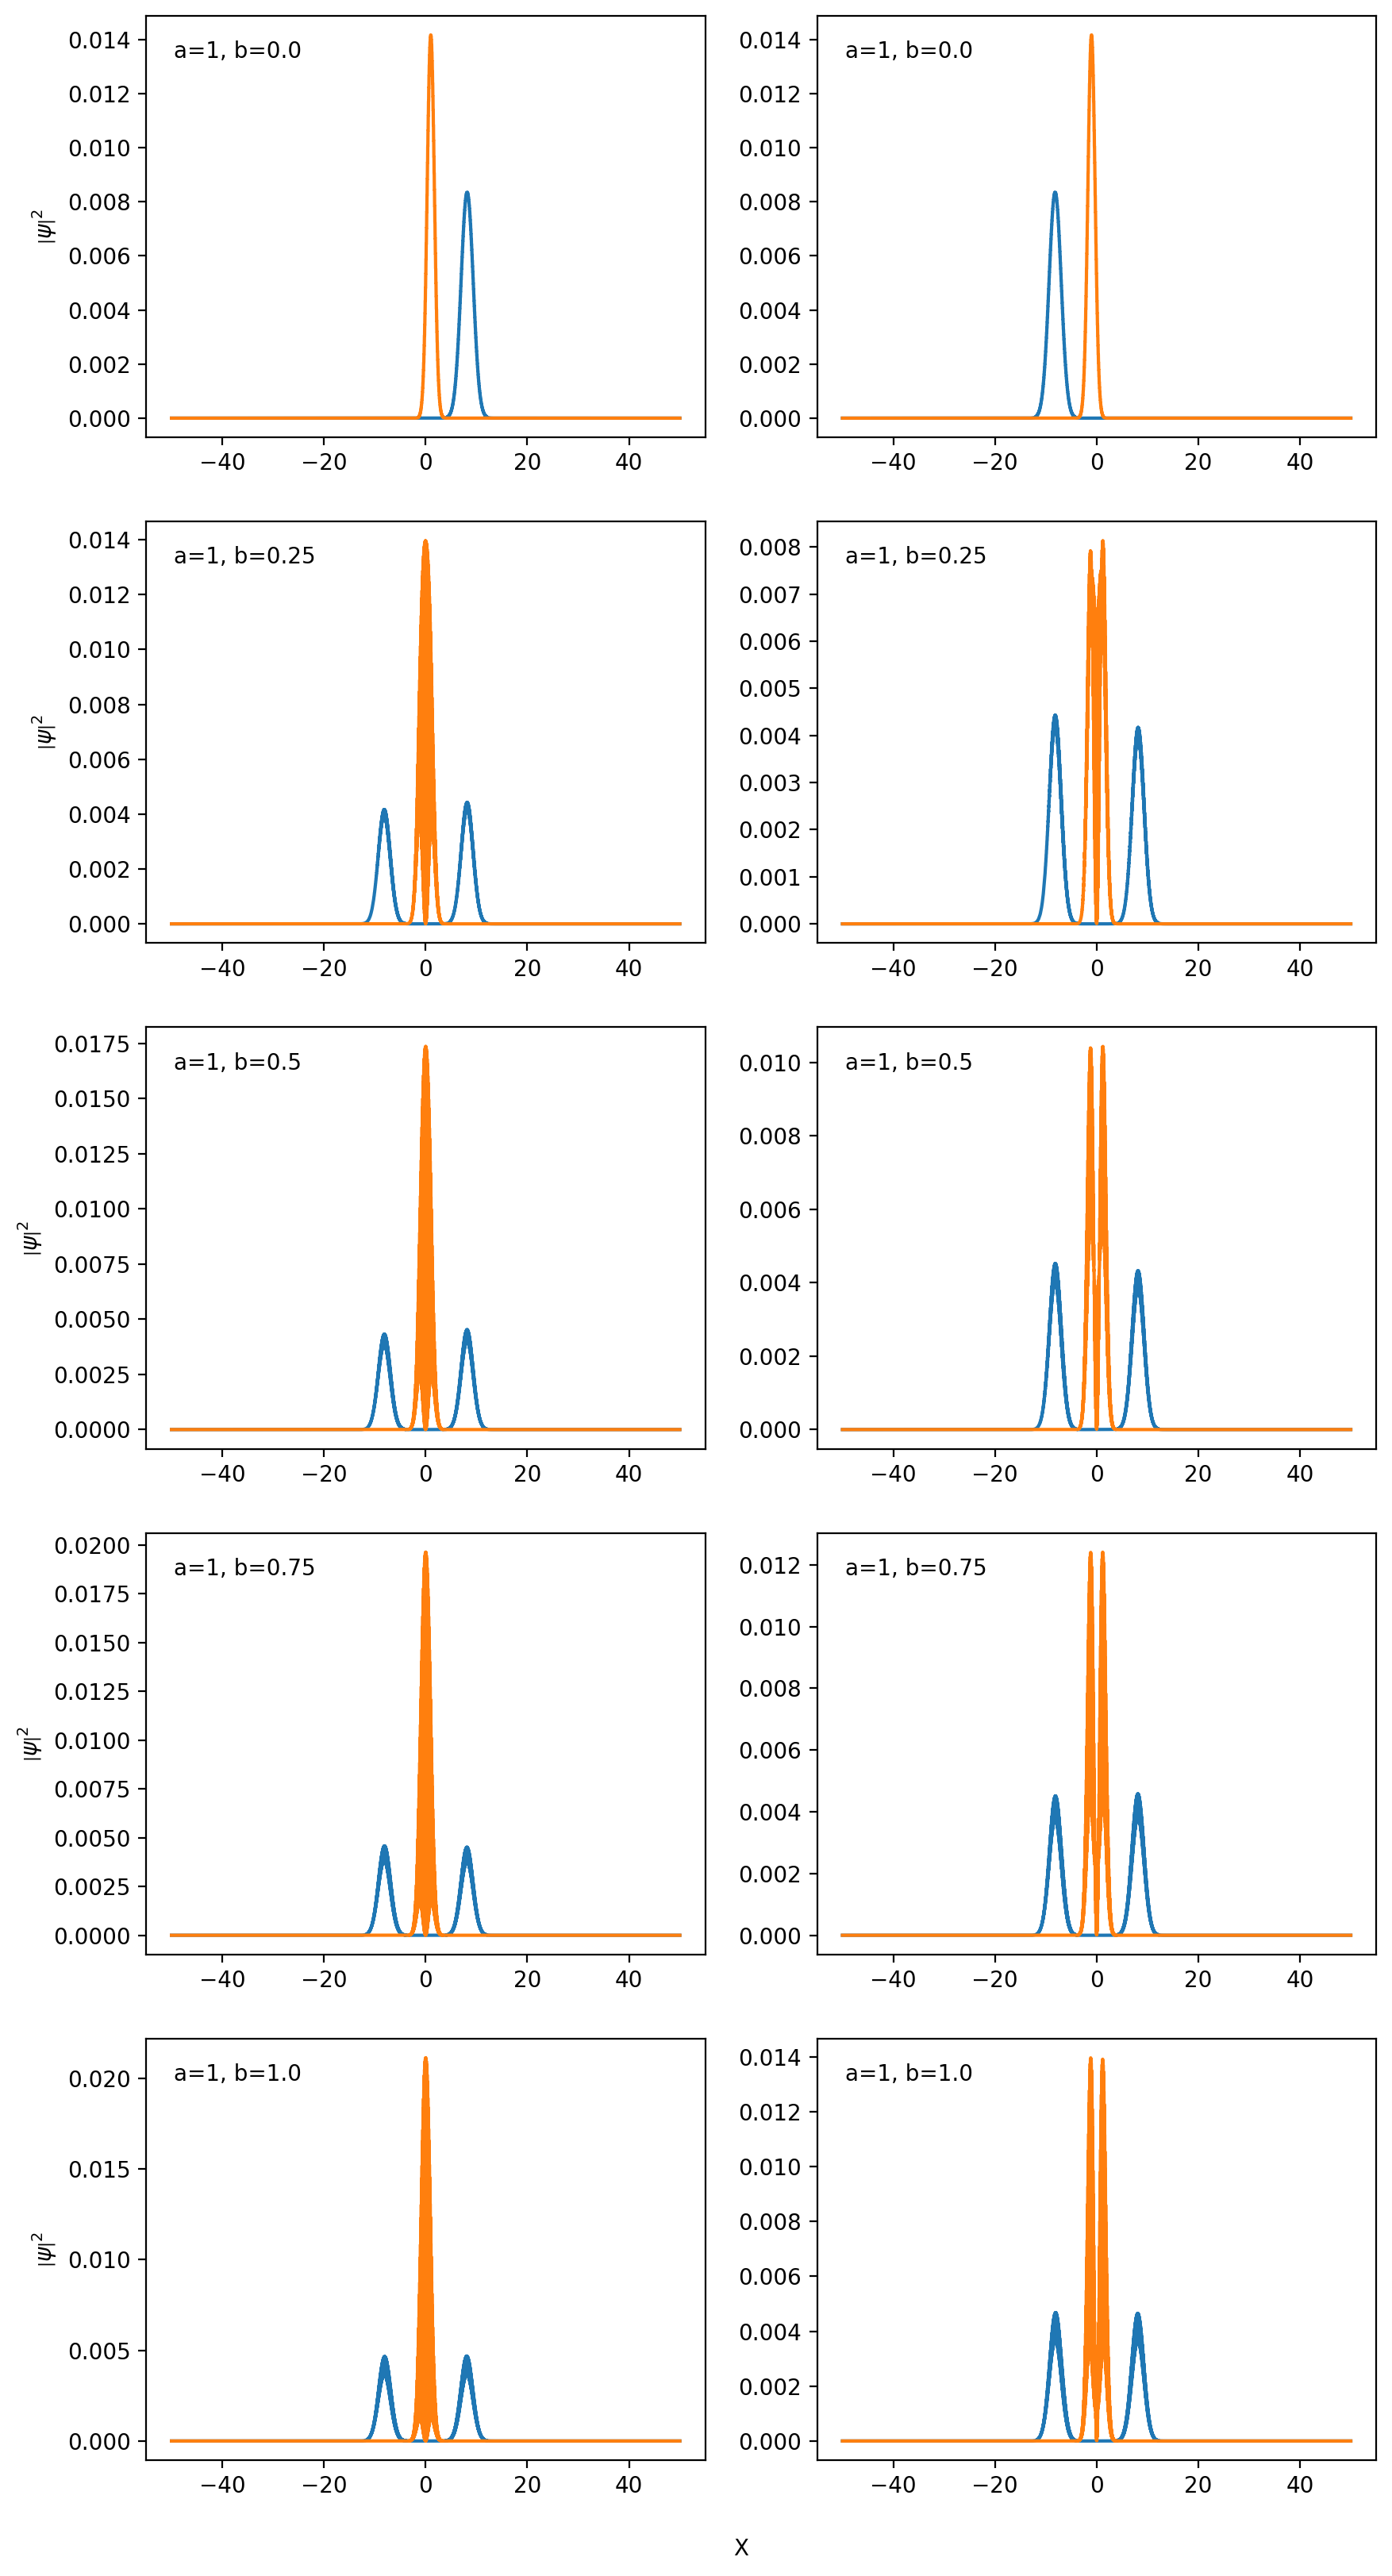

In [9]:
# Example: a=1
def plot_graph(ax, a, b, v):
    ax.plot(X2, np.abs(psi[0,a,b][v])**2) 
    ax.plot(X2, np.abs(psit[a,b,v,5000])**2)
    ax.text(0.05, 0.9, f'a={a}, b={b}', transform=ax.transAxes)

fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    a=1
    b = i * 0.25
    plot_graph(axs[i, 0], a, b, 0)
    plot_graph(axs[i, 1], a, b, 1)
    axs[i, 0].set_ylabel('$\\left|\\psi\\right|^2$')

fig.text(0.5, 0.08, 'X', ha='center')

plt.show()

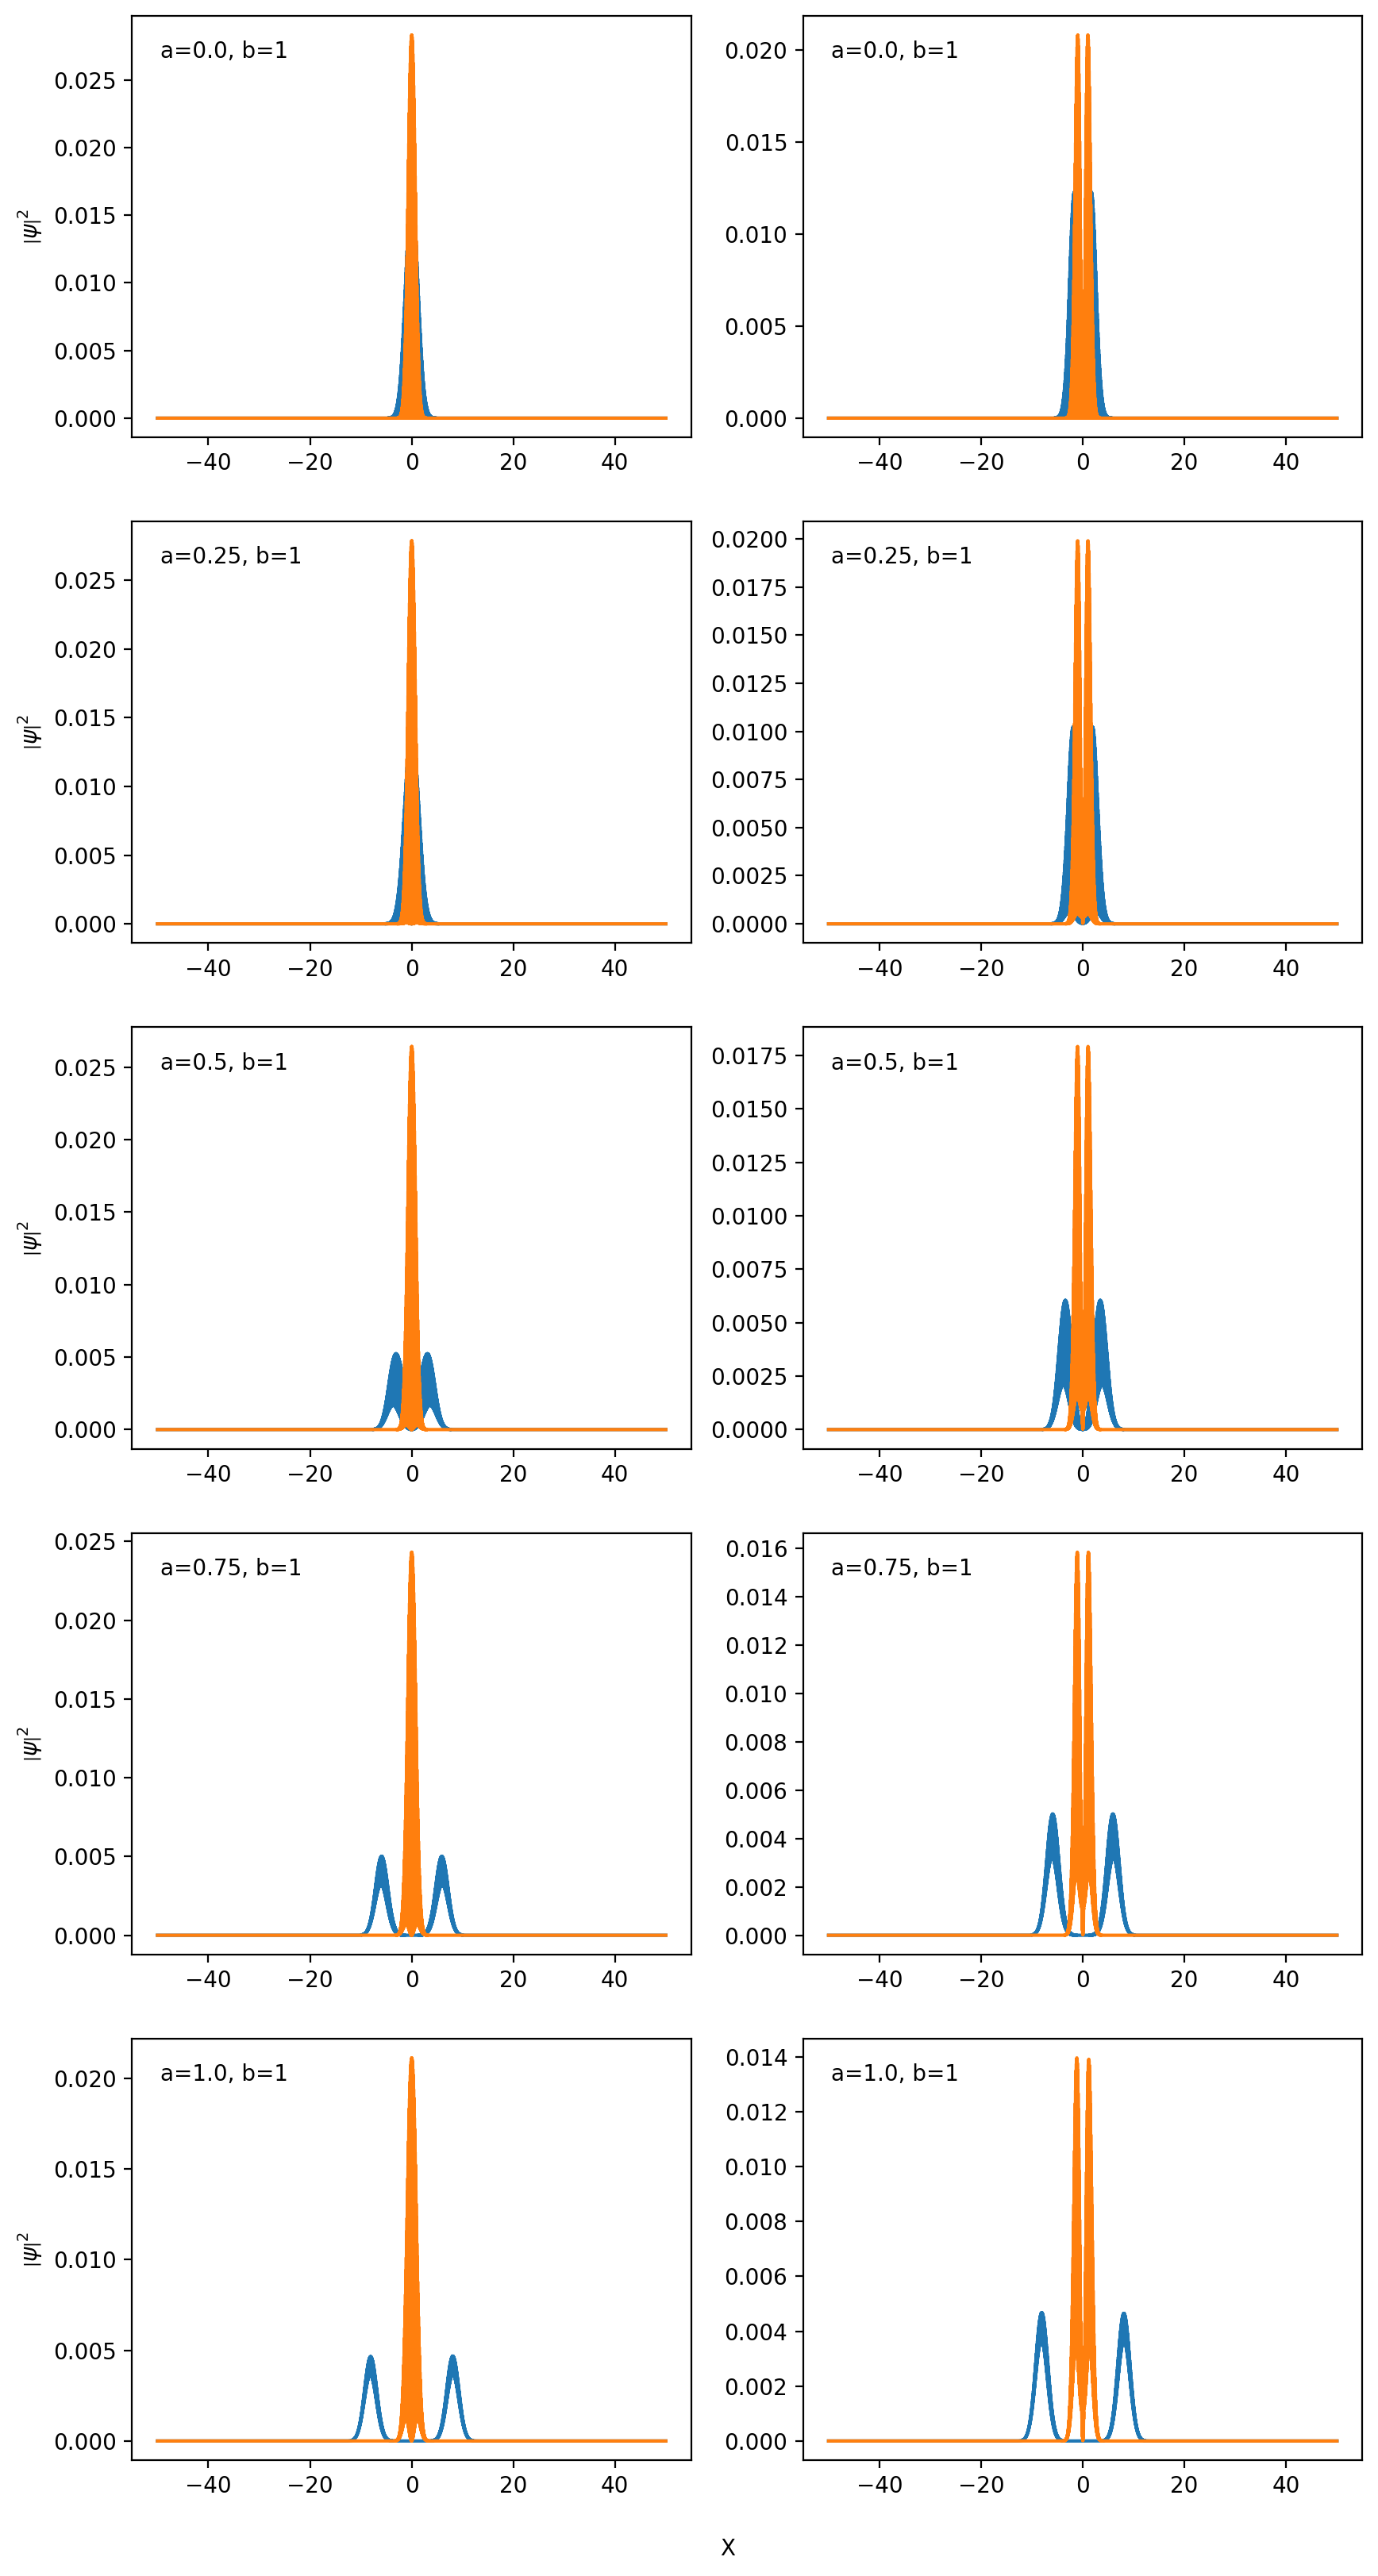

In [10]:
# Example: b=1
def plot_graph(ax, a, b, v):
    ax.plot(X2, np.abs(psi[0,a,b][v])**2) 
    ax.plot(X2, np.abs(psit[a,b,v,5000])**2)
    ax.text(0.05, 0.9, f'a={a}, b={b}', transform=ax.transAxes)

fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    b=1
    a = i * 0.25
    plot_graph(axs[i, 0], a, b, 0)
    plot_graph(axs[i, 1], a, b, 1)
    axs[i, 0].set_ylabel('$\\left|\\psi\\right|^2$')

fig.text(0.5, 0.08, 'X', ha='center')

plt.show()